## XGBoost


RUN: XGBOOST + HEDGING | HORIZON = MONTHLY
Horizon: monthly
Predictors (lags): ['EUR_NOK', 'Brent', 'OSEBX', 'StoxEurope', 'Q', 'd_pi', 'dI_t']
Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416

Dropped periods and reasons:
  2000-01: no_cut
  2000-02: hist<40
  2000-03: hist<40

=== XGB forecast performance ===
Horizon: monthly
Obs: 308
RMSE: 0.148279
MAE : 0.100245
Directional accuracy: 211/307 (68.7%)


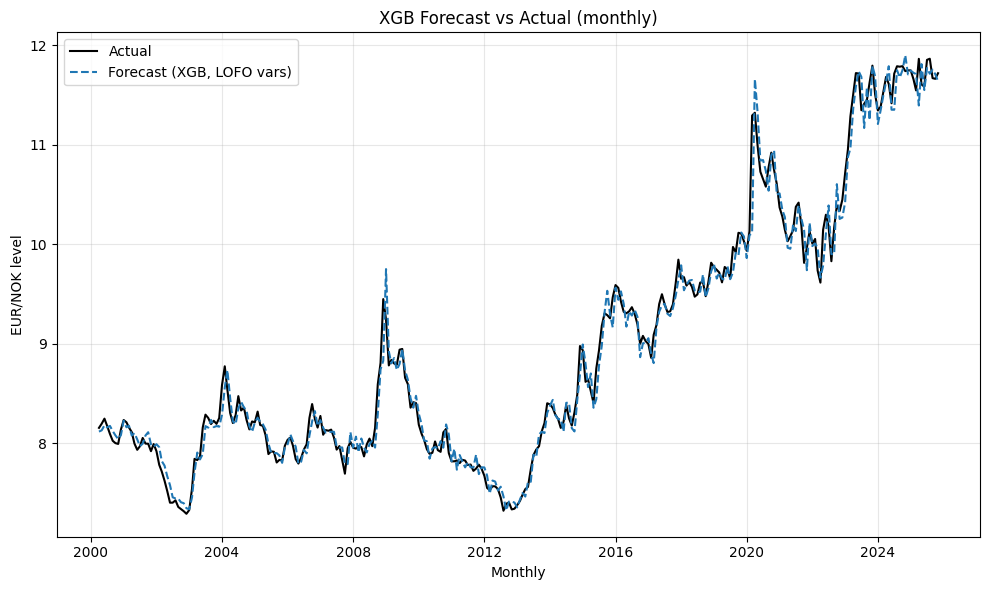

Saved: XGB_Forecast_M.png

=== Hedging backtest (directional) ===
Horizon    : monthly
Exposure   : EUR_cost
Rule       : binary
Hedge cost : 0.00 bps/period
Mean r (unhedged): -0.00133 | Vol: 0.01759 | Sharpe~: -0.263
Mean r (hedged)  : 0.00255 | Vol: 0.01219 | Sharpe~: 0.725

=== Øre-/NOK-forbedring (hedged minus unhedged) ===
EUR notional: 1,000,000
Mean improvement: 3.445 øre/EUR per period | 38.83 bps/period
Median: 0.000 øre/EUR | P10/P90: -3.036/17.646
Share positive: 33.2%
Total improvement: 10,576,234 NOK over sample


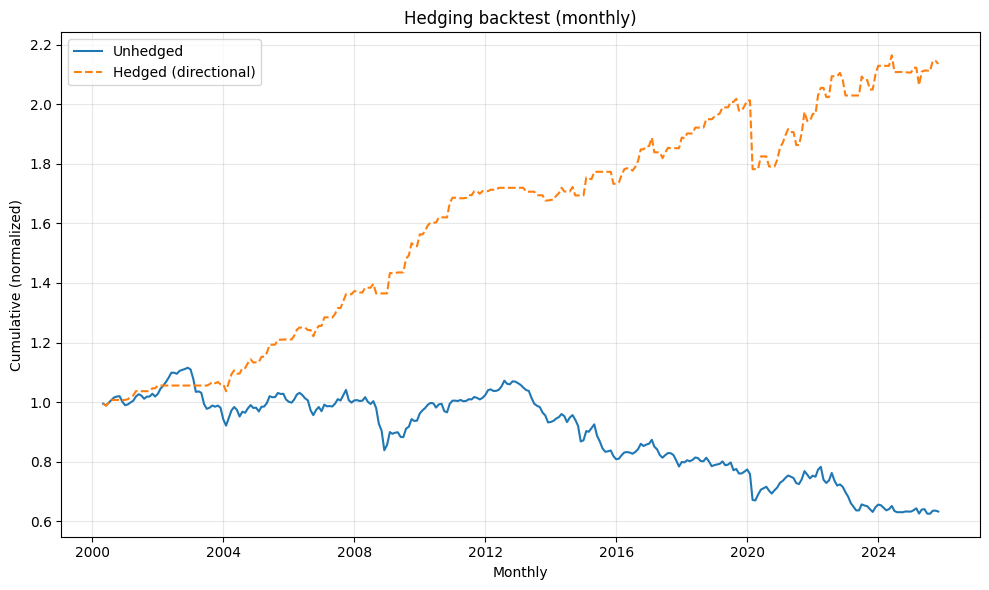

Saved: XGB_HedgingBacktest_M.png

RUN: XGBOOST + HEDGING | HORIZON = QUARTERLY
Horizon: quarterly
Predictors (lags): ['EUR_NOK', 'VIX', 'StoxEurope', 'SP500', 'OSEBX', 'OBX_Energy', 'Q', 'd_pi', 'dI_t']
Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416

Dropped periods and reasons:
  2000Q1: no_cut

=== XGB forecast performance ===
Horizon: quarterly
Obs: 103
RMSE: 0.204954
MAE : 0.146265
Directional accuracy: 77/102 (75.5%)


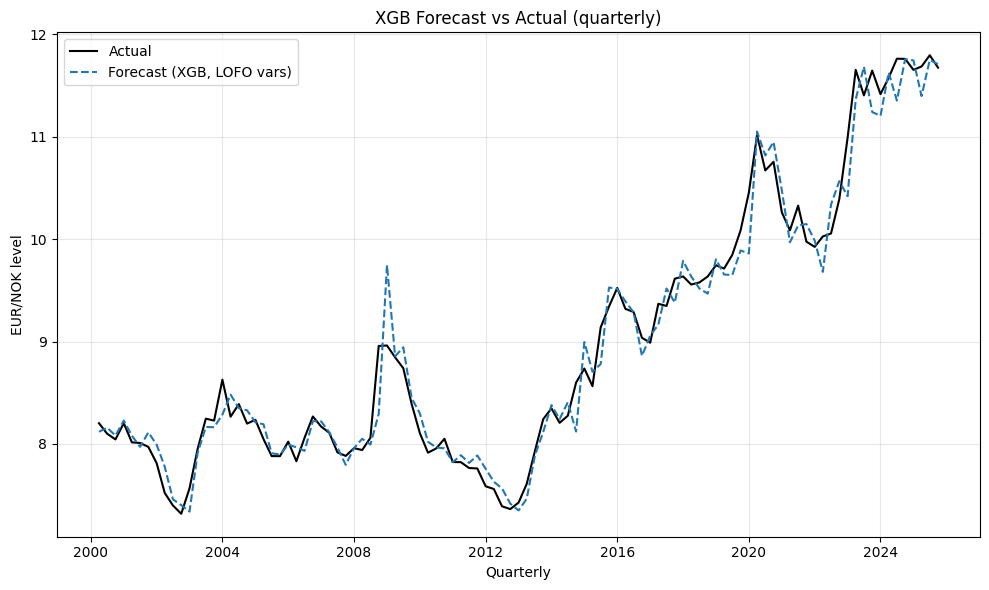

Saved: XGB_Forecast_Q.png

=== Hedging backtest (directional) ===
Horizon    : quarterly
Exposure   : EUR_cost
Rule       : binary
Hedge cost : 0.00 bps/period
Mean r (unhedged): -0.00381 | Vol: 0.02649 | Sharpe~: -0.287
Mean r (hedged)  : 0.00546 | Vol: 0.01401 | Sharpe~: 0.780

=== Øre-/NOK-forbedring (hedged minus unhedged) ===
EUR notional: 1,000,000
Mean improvement: 8.178 øre/EUR per period | 92.69 bps/period
Median: 0.000 øre/EUR | P10/P90: -2.073/31.019
Share positive: 38.2%
Total improvement: 8,341,584 NOK over sample


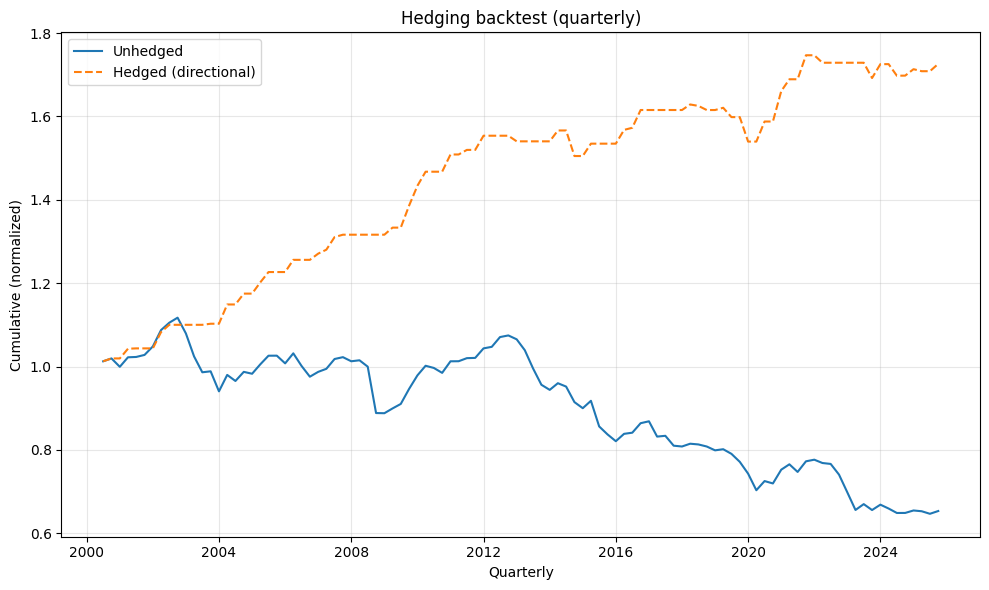

Saved: XGB_HedgingBacktest_Q.png


In [2]:
!pip -q install pandas numpy scikit-learn matplotlib requests certifi joblib xgboost

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List

import numpy as np
import pandas as pd
import requests, certifi
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from joblib import Parallel, delayed


# =============================
# CONFIG
# =============================
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )

    # Walk-forward / lags
    max_lags: int = 20
    min_hist_days: int = 40
    max_horizon_month: int = 64
    max_horizon_quarter: int = 128

    # XGB params (capped)
    n_estimators: int = 150
    learning_rate: float = 0.04
    max_depth: int = 6
    min_child_weight: float = 7.0
    subsample: float = 0.6
    colsample_bytree: float = 1.0
    gamma: float = 0.05
    reg_alpha: float = 0.2
    reg_lambda: float = 0.5
    random_state: int = 42

    # Hedging
    # exposure:
    #   "EUR_asset" = long EUR (aktivum i NOK)
    #   "EUR_cost"  = EUR-kostnad (short EUR i NOK-termer)
    exposure: str = "EUR_cost"

    # hedge_rule: "binary" (0/1) eller "sigmoid" ([0,1])
    hedge_rule: str = "binary"
    sigmoid_k: float = 8.0
    vol_lookback: int = 12

    hedge_cost_bps: float = 0.0  # per period (monthly/quarterly)

    # Kvantifisering
    eur_notional: float = 1_000_000.0  # for NOK/øre-rapportering

    # IO
    retries: int = 3
    timeout: int = 60
    verbose: bool = True

CFG = Config()
TARGET = "EUR_NOK"


# =============================
# LOFO variable sets (XGB)
# =============================
XGB_COV_MONTHLY = ["Brent", "OSEBX", "StoxEurope", "Q", "d_pi", "dI_t"]
XGB_COV_QUARTER = ["VIX", "StoxEurope", "SP500", "OSEBX", "OBX_Energy", "Q", "d_pi", "dI_t"]


# =============================
# HELPERS
# =============================
ALIASES = {
    "OBX_EN": ["OBX_Energy", "OBX_EN", "OBX_ENERGY"],
    "OBX_Energy": ["OBX_Energy", "OBX_EN", "OBX_ENERGY"],
    "q_t": ["Q", "q_t", "q"],
    "Q": ["Q", "q_t", "q"],
}

def resolve_columns(df_cols: List[str], wanted: List[str]) -> List[str]:
    cols = set(df_cols)
    out = []
    for w in wanted:
        if w in cols:
            out.append(w); continue
        if w in ALIASES:
            found = next((a for a in ALIASES[w] if a in cols), None)
            if found:
                out.append(found); continue
        raise ValueError(f"Missing column: {w}. Available sample: {sorted(cols)[:30]}")
    return out

def download_csv_text(url: str, retries: int, timeout: int) -> str:
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                time.sleep(1.5 * k)
    raise RuntimeError(f"Download failed: {last_err}")

def load_series(cfg: Config, predictors: List[str]) -> Tuple[pd.Series, pd.DataFrame, List[str]]:
    text = download_csv_text(cfg.url, cfg.retries, cfg.timeout)
    raw = pd.read_csv(io.StringIO(text))
    if "Date" not in raw.columns:
        raise ValueError("CSV must contain column 'Date'.")

    predictors_resolved = resolve_columns(list(raw.columns), predictors)
    use_cols = ["Date"] + predictors_resolved

    df = (
        raw[use_cols]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET])
        .sort_values("DATE")
        .set_index("DATE")
    )

    for c in predictors_resolved:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=[TARGET])
    if df.empty:
        raise ValueError("Dataset empty after cleaning.")

    # Business-day truth series
    S_b = df[TARGET].asfreq("B").ffill().astype(float)
    S_b.name = TARGET

    # Calendar-day panel inputs
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d, predictors_resolved

def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None

def make_lag_matrix(df_hist: pd.DataFrame, predictors: List[str], max_lags: int):
    work = df_hist[predictors].copy()
    lag_cols: List[str] = []
    for var in predictors:
        for k in range(1, max_lags + 1):
            nm = f"{var}_lag{k}"
            work[nm] = work[var].shift(k)
            lag_cols.append(nm)

    work = work.dropna()
    if work.empty:
        return np.empty((0,0)), np.empty((0,)), lag_cols

    X = work[lag_cols].values
    y = work[TARGET].values
    return X, y, lag_cols

def fit_xgb_one_step(cfg: Config, df_hist_daily: pd.DataFrame, predictors: List[str]) -> XGBRegressor:
    X, y, _ = make_lag_matrix(df_hist_daily, predictors, cfg.max_lags)
    if len(X) < 5:
        raise ValueError("Too few observations after lagging.")

    model = XGBRegressor(
        n_estimators=cfg.n_estimators,
        learning_rate=cfg.learning_rate,
        max_depth=cfg.max_depth,
        subsample=cfg.subsample,
        colsample_bytree=cfg.colsample_bytree,
        min_child_weight=cfg.min_child_weight,
        gamma=cfg.gamma,
        reg_alpha=cfg.reg_alpha,
        reg_lambda=cfg.reg_lambda,
        objective="reg:squarederror",
        eval_metric="rmse",
        tree_method="hist",
        random_state=cfg.random_state,
        n_jobs=1
    )
    model.fit(X, y)
    return model

def recursive_daily_forecast(cfg: Config, model: XGBRegressor, df_hist_daily: pd.DataFrame, predictors: List[str], H: int) -> pd.Series:
    # Past-only: freeze non-target predictors at last observed level; only TARGET updates
    hist = df_hist_daily[predictors].copy()
    last_vals = hist.iloc[-1].to_dict()

    preds = []
    for _ in range(H):
        row_feats = []
        for var in predictors:
            lags = hist[var].iloc[-cfg.max_lags:][::-1].values
            row_feats.extend(lags.tolist())

        x = np.array(row_feats, dtype=float).reshape(1, -1)
        yhat = float(model.predict(x)[0])
        preds.append(yhat)

        new_row = last_vals.copy()
        new_row[TARGET] = yhat
        new_idx = hist.index[-1] + pd.Timedelta(days=1)
        hist = pd.concat([hist, pd.DataFrame([new_row], index=[new_idx])])

    return pd.Series(preds)

def walk_forward_xgb(cfg: Config, horizon: str, S_b: pd.Series, DF_d: pd.DataFrame, predictors: List[str]) -> pd.DataFrame:
    horizon = horizon.lower()
    if horizon == "monthly":
        freq, max_h, key = "M", cfg.max_horizon_month, "month"
    elif horizon == "quarterly":
        freq, max_h, key = "Q-DEC", cfg.max_horizon_quarter, "quarter"
    else:
        raise ValueError("horizon must be 'monthly' or 'quarterly'.")

    periods = pd.period_range(pd.Period(S_b.index.min(), freq=freq),
                              pd.Period(S_b.index.max(), freq=freq), freq=freq)

    def _one(p: pd.Period):
        prev = p - 1
        p_start, p_end = p.start_time, p.end_time
        prev_start, prev_end = prev.start_time, prev.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            return (str(p), None, "no_cut")

        hist_df = DF_d.loc[:cut]
        if hist_df.shape[0] < cfg.min_hist_days:
            return (str(p), None, f"hist<{cfg.min_hist_days}")
        if hist_df.shape[0] <= cfg.max_lags + 1:
            return (str(p), None, "hist<=max_lags")

        idx_b = S_b.index[(S_b.index >= p_start) & (S_b.index <= p_end)]
        if idx_b.size < 1:
            return (str(p), None, "no_bdays")
        y_true = float(S_b.loc[idx_b].mean())

        H = (p_end.date() - p_start.date()).days + 1
        if H <= 0 or H > max_h:
            return (str(p), None, f"horizon_invalid(H={H})")

        model = fit_xgb_one_step(cfg, hist_df, predictors)
        pf = recursive_daily_forecast(cfg, model, hist_df, predictors, H)

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf.values, index=f_idx)

        pred_b = pred_daily.reindex(idx_b, method=None)
        if pred_b.isna().all():
            return (str(p), None, "no_overlap_pred_B")
        y_pred = float(pred_b.dropna().mean())

        return (str(p), {key: p, "cut": cut, "y_true": y_true, "y_pred": y_pred}, None)

    res = Parallel(n_jobs=-1, backend="loky")(delayed(_one)(p) for p in periods)

    rows, dropped = {}, {}
    for k, row, reason in res:
        if row is not None:
            rows[k] = row
        else:
            dropped[k] = reason or "unknown"

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index(key).sort_index()

    if cfg.verbose and dropped:
        print("\nDropped periods and reasons:")
        for k, v in dropped.items():
            print(f"  {k}: {v}")

    return df


# =============================
# EVAL + HEDGING + ØRE
# =============================
def evaluate_forecast(cfg: Config, horizon: str, eval_df: pd.DataFrame) -> pd.DataFrame:
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true","y_pred"]).copy()

    rmse = float(np.sqrt(np.mean(core["err"]**2))) if len(core) else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if len(core) else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = hits/total if total else np.nan

    print("\n=== XGB forecast performance ===")
    print(f"Horizon: {horizon}")
    print(f"Obs: {len(core)}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE : {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core

def _sigmoid(x: float) -> float:
    return 1.0/(1.0+math.exp(-x))

def hedge_backtest(cfg: Config, horizon: str, core: pd.DataFrame) -> pd.DataFrame:
    df = core.copy()
    df["y_prev"] = df["y_true"].shift(1)
    df = df.dropna(subset=["y_prev"]).copy()

    # Realized FX return (levels -> simple return)
    df["r_fx"]  = df["y_true"]/df["y_prev"] - 1.0
    df["r_hat"] = df["y_pred"]/df["y_prev"] - 1.0

    if cfg.exposure not in ("EUR_asset","EUR_cost"):
        raise ValueError("exposure must be 'EUR_asset' or 'EUR_cost'.")

    sign = -1.0 if cfg.exposure == "EUR_asset" else +1.0

    if cfg.hedge_rule == "binary":
        df["hedge_ratio"] = (sign * df["r_hat"] > 0).astype(float)
    elif cfg.hedge_rule == "sigmoid":
        vol = df["r_fx"].rolling(cfg.vol_lookback, min_periods=3).std().replace(0, np.nan)
        scale = vol.fillna(vol.median() if np.isfinite(vol.median()) else 1e-6)
        z = (sign * df["r_hat"]) / (scale + 1e-12)
        df["hedge_ratio"] = z.apply(lambda v: _sigmoid(cfg.sigmoid_k * float(v))).clip(0,1)
    else:
        raise ValueError("hedge_rule must be 'binary' or 'sigmoid'.")

    df["r_unhedged"] = df["r_fx"] if cfg.exposure == "EUR_asset" else -df["r_fx"]
    cost = (cfg.hedge_cost_bps/10000.0)
    df["r_hedged"] = (1.0 - df["hedge_ratio"]) * df["r_unhedged"] - cost

    df["cum_unhedged"] = (1.0 + df["r_unhedged"]).cumprod()
    df["cum_hedged"]   = (1.0 + df["r_hedged"]).cumprod()

    ann = math.sqrt(12) if horizon.lower() == "monthly" else math.sqrt(4)
    mu_u, sd_u = df["r_unhedged"].mean(), df["r_unhedged"].std(ddof=1)
    mu_h, sd_h = df["r_hedged"].mean(), df["r_hedged"].std(ddof=1)
    sharpe_u = (mu_u/(sd_u+1e-12))*ann
    sharpe_h = (mu_h/(sd_h+1e-12))*ann

    print("\n=== Hedging backtest (directional) ===")
    print(f"Horizon    : {horizon}")
    print(f"Exposure   : {cfg.exposure}")
    print(f"Rule       : {cfg.hedge_rule}")
    print(f"Hedge cost : {cfg.hedge_cost_bps:.2f} bps/period")
    print(f"Mean r (unhedged): {mu_u:.5f} | Vol: {sd_u:.5f} | Sharpe~: {sharpe_u:.3f}")
    print(f"Mean r (hedged)  : {mu_h:.5f} | Vol: {sd_h:.5f} | Sharpe~: {sharpe_h:.3f}")

    return df

def quantify_ore_improvement(cfg: Config, bt: pd.DataFrame) -> pd.DataFrame:
    """
    Øre-/NOK-kvantifisering per periode:
      - PnL_NOK = r * (EUR_notional * S_prev)
      - improvement_NOK = PnL_hedged - PnL_unhedged
      - improvement_øre/EUR = 100 * improvement_NOK / EUR_notional
      - improvement_bps = 10000 * improvement_NOK / (EUR_notional * S_prev)
    """
    df = bt.copy()
    EURN = float(cfg.eur_notional)

    df["S_prev"] = df["y_prev"].astype(float)
    df["base_nok"] = EURN * df["S_prev"]

    df["pnl_unhedged_nok"] = df["r_unhedged"] * df["base_nok"]
    df["pnl_hedged_nok"]   = df["r_hedged"]   * df["base_nok"]

    df["improvement_nok"] = df["pnl_hedged_nok"] - df["pnl_unhedged_nok"]
    df["improvement_ore_per_eur"] = 100.0 * (df["improvement_nok"] / EURN)
    df["improvement_bps"] = 10000.0 * (df["improvement_nok"] / (df["base_nok"] + 1e-12))

    ore = df["improvement_ore_per_eur"].dropna()
    bps = df["improvement_bps"].dropna()

    print("\n=== Øre-/NOK-forbedring (hedged minus unhedged) ===")
    print(f"EUR notional: {EURN:,.0f}")
    print(f"Mean improvement: {ore.mean():.3f} øre/EUR per period | {bps.mean():.2f} bps/period")
    print(f"Median: {ore.median():.3f} øre/EUR | P10/P90: {ore.quantile(0.10):.3f}/{ore.quantile(0.90):.3f}")
    print(f"Share positive: {(ore.gt(0).mean()*100):.1f}%")
    print(f"Total improvement: {(df['improvement_nok'].sum()):,.0f} NOK over sample")

    return df

def plot_forecast(core: pd.DataFrame, horizon: str, path: str):
    x = core.index.to_timestamp() if isinstance(core.index, pd.PeriodIndex) else core.index
    plt.figure(figsize=(10,6))
    plt.plot(x, core["y_true"], color="black", label="Actual")
    plt.plot(x, core["y_pred"], color="tab:blue", linestyle="--", label="Forecast (XGB, LOFO vars)")
    plt.title(f"XGB Forecast vs Actual ({horizon})")
    plt.xlabel(horizon.capitalize())
    plt.ylabel("EUR/NOK level")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved: {path}")

def plot_hedge(bt: pd.DataFrame, horizon: str, path: str):
    x = bt.index.to_timestamp() if isinstance(bt.index, pd.PeriodIndex) else bt.index
    plt.figure(figsize=(10,6))
    plt.plot(x, bt["cum_unhedged"], label="Unhedged")
    plt.plot(x, bt["cum_hedged"], linestyle="--", label="Hedged (directional)")
    plt.title(f"Hedging backtest ({horizon})")
    plt.xlabel(horizon.capitalize())
    plt.ylabel("Cumulative (normalized)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved: {path}")


# =============================
# RUNNERS
# =============================
def run_one(cfg: Config, horizon: str):
    horizon = horizon.lower()
    cov = XGB_COV_MONTHLY if horizon == "monthly" else XGB_COV_QUARTER
    predictors = [TARGET] + cov

    print("\n" + "="*90)
    print(f"RUN: XGBOOST + HEDGING | HORIZON = {horizon.upper()}")
    print("="*90)

    S_b, DF_d, predictors_resolved = load_series(cfg, predictors)

    if cfg.verbose:
        print(f"Horizon: {horizon}")
        print(f"Predictors (lags): {predictors_resolved}")
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")

    df_eval = walk_forward_xgb(cfg, horizon, S_b, DF_d, predictors_resolved)
    core = evaluate_forecast(cfg, horizon, df_eval)

    suffix = "M" if horizon == "monthly" else "Q"
    fig_forecast = f"XGB_Forecast_{suffix}.png"
    fig_hedge    = f"XGB_HedgingBacktest_{suffix}.png"

    plot_forecast(core, horizon, fig_forecast)

    bt = hedge_backtest(cfg, horizon, core)
    bt = quantify_ore_improvement(cfg, bt)
    plot_hedge(bt, horizon, fig_hedge)


def main():
    # Kjør begge
    run_one(CFG, "monthly")
    run_one(CFG, "quarterly")


if __name__ == "__main__":
    main()


## Chronos

In [3]:
!pip install chronos-forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 8.1 MB/s eta 0:00:00


In [4]:


import pandas as pd
from chronos import BaseChronosPipeline

pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cuda")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/478M [00:00<?, ?B/s]


MODEL: Chronos2_BASE
Monthly covariates (resolved):  ['VIX', 'SP500', 'StoxEurope', 'OSEBX', 'OBX_Energy', 'dI_t']
Quarterly covariates (resolved): ['VIX', 'SP500', 'Q']
Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416

RUN: Chronos2_BASE | HORIZON = MONTHLY

Dropped months and reasons:
  2000-01: no_cut
  2000-02: hist<40
  2000-03: hist<40

=== Chronos2_BASE | Forecast performance (monthly) ===
Obs: 308
RMSE: 0.141499
MAE : 0.095839
Directional accuracy: 212/307 (69.1%)


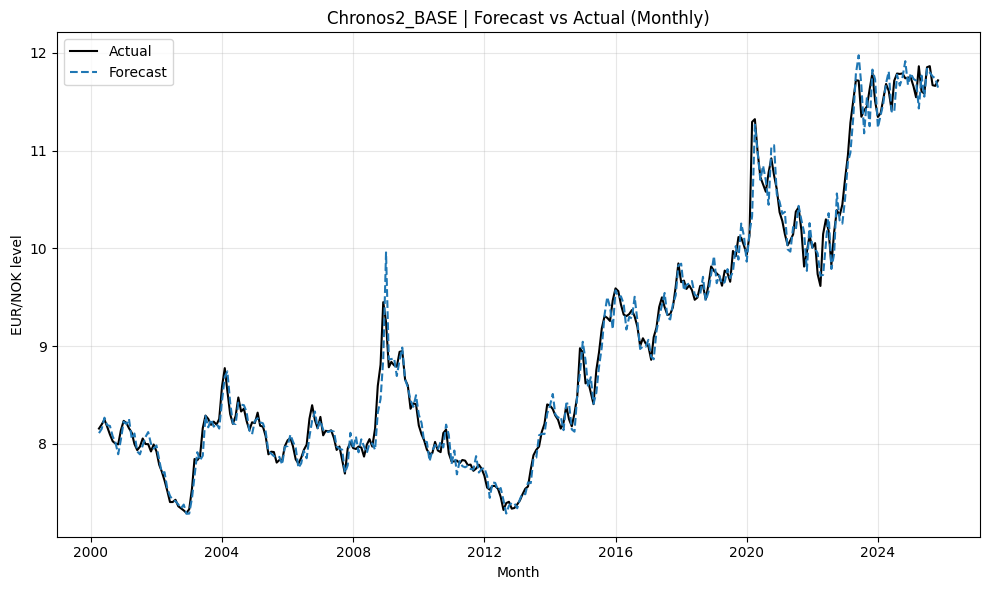

Saved: Chronos2_BASE_Forecast_M.png

=== Chronos2_BASE | Hedging backtest (monthly) ===
Exposure   : EUR_cost
Rule       : binary
Hedge cost : 0.00 bps/period
Mean r (unhedged): -0.00133 | Vol: 0.01759 | Sharpe~: -0.263
Mean r (hedged)  : 0.00332 | Vol: 0.01006 | Sharpe~: 1.143

=== Chronos2_BASE | Øre-/NOK-forbedring (monthly) ===
EUR notional: 1,000,000
Mean improvement: 4.162 øre/EUR per period | 46.51 bps/period
Median: 0.000 øre/EUR | P10/P90: -3.036/18.982
Share positive: 32.6%
Total improvement: 12,777,701 NOK over sample


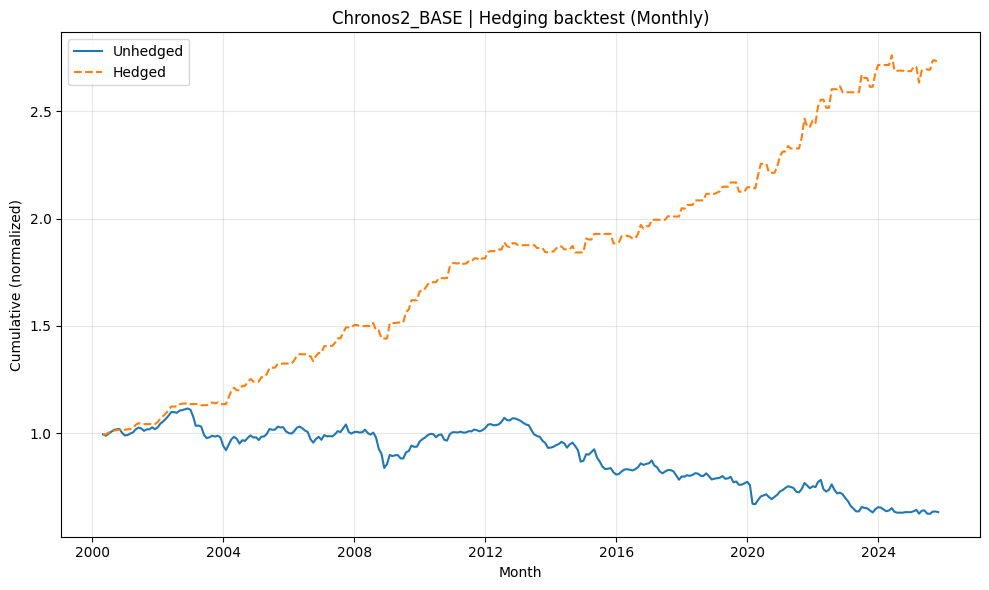

Saved: Chronos2_BASE_Hedge_M.png

RUN: Chronos2_BASE | HORIZON = QUARTERLY

Dropped quarters and reasons:
  2000Q1: no_cut

=== Chronos2_BASE | Forecast performance (quarterly) ===
Obs: 103
RMSE: 0.197095
MAE : 0.142733
Directional accuracy: 80/102 (78.4%)


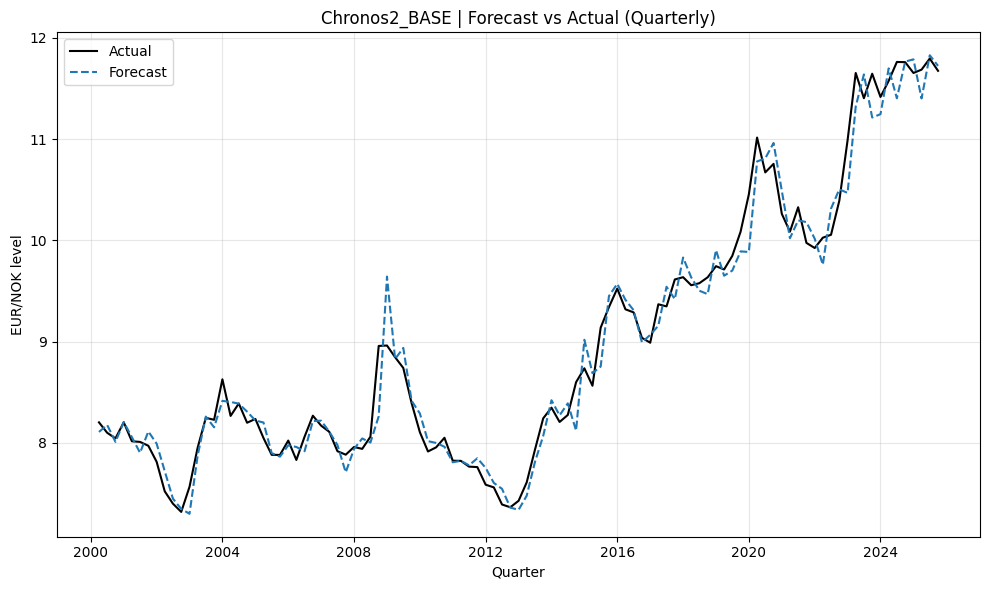

Saved: Chronos2_BASE_Forecast_Q.png

=== Chronos2_BASE | Hedging backtest (quarterly) ===
Exposure   : EUR_cost
Rule       : binary
Hedge cost : 0.00 bps/period
Mean r (unhedged): -0.00381 | Vol: 0.02649 | Sharpe~: -0.287
Mean r (hedged)  : 0.00561 | Vol: 0.01469 | Sharpe~: 0.764

=== Chronos2_BASE | Øre-/NOK-forbedring (quarterly) ===
EUR notional: 1,000,000
Mean improvement: 8.346 øre/EUR per period | 94.21 bps/period
Median: 0.000 øre/EUR | P10/P90: -0.163/31.019
Share positive: 37.3%
Total improvement: 8,513,169 NOK over sample


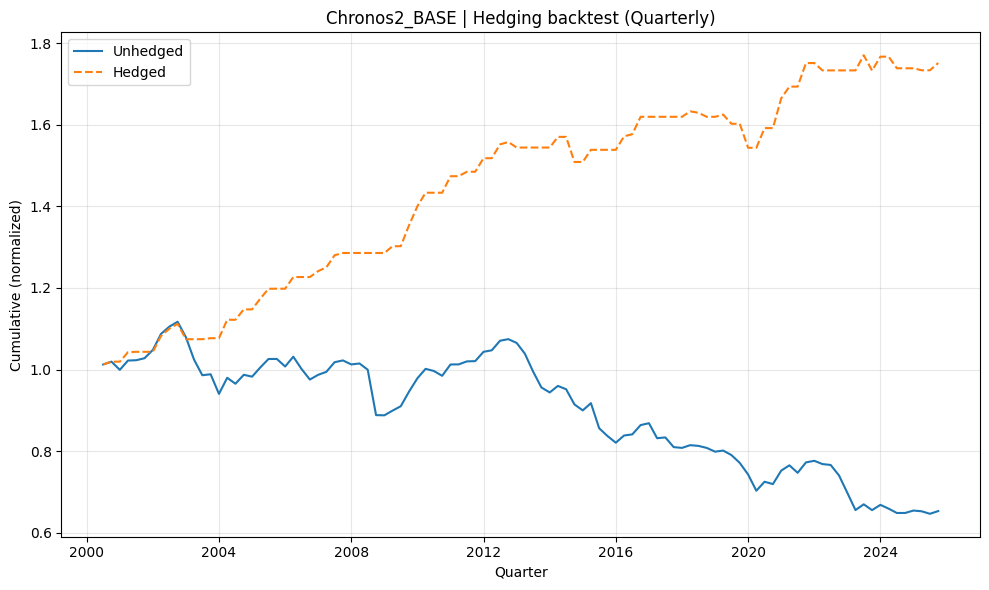

Saved: Chronos2_BASE_Hedge_Q.png

FINETUNE PANEL
Panel: 1980-12-10 → 1999-12-31 | n=4930
Best params: FTConfig(prediction_length=32, num_steps=20, learning_rate=5e-06, batch_size=4, logging_steps=10)

[Fine-tuning Chronos-2 on NB FX panel]
  series_used=11
  pred_len=32, steps=20, lr=5e-06, bs=4


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.145500
20,1.310100



MODEL: Chronos2_FINETUNED
Monthly covariates (resolved):  ['VIX', 'SP500', 'StoxEurope', 'OSEBX', 'OBX_Energy', 'dI_t']
Quarterly covariates (resolved): ['VIX', 'SP500', 'Q']
Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416

RUN: Chronos2_FINETUNED | HORIZON = MONTHLY

Dropped months and reasons:
  2000-01: no_cut
  2000-02: hist<40
  2000-03: hist<40

=== Chronos2_FINETUNED | Forecast performance (monthly) ===
Obs: 308
RMSE: 0.144403
MAE : 0.098264
Directional accuracy: 201/307 (65.5%)


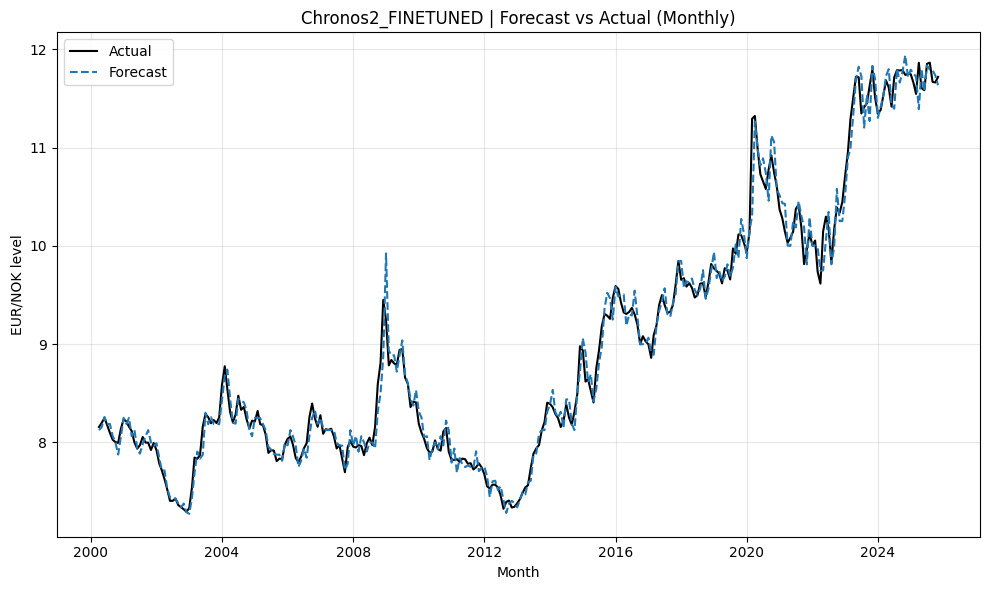

Saved: Chronos2_FINETUNED_Forecast_M.png

=== Chronos2_FINETUNED | Hedging backtest (monthly) ===
Exposure   : EUR_cost
Rule       : binary
Hedge cost : 0.00 bps/period
Mean r (unhedged): -0.00133 | Vol: 0.01759 | Sharpe~: -0.263
Mean r (hedged)  : 0.00280 | Vol: 0.00962 | Sharpe~: 1.009

=== Chronos2_FINETUNED | Øre-/NOK-forbedring (monthly) ===
EUR notional: 1,000,000
Mean improvement: 3.651 øre/EUR per period | 41.37 bps/period
Median: 0.000 øre/EUR | P10/P90: -5.824/18.982
Share positive: 32.6%
Total improvement: 11,209,509 NOK over sample


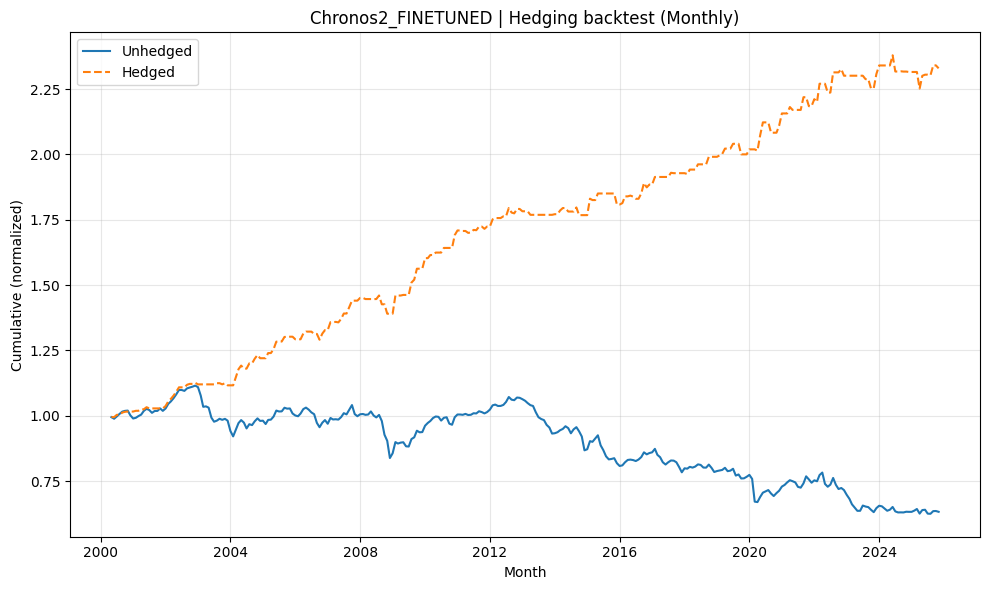

Saved: Chronos2_FINETUNED_Hedge_M.png

RUN: Chronos2_FINETUNED | HORIZON = QUARTERLY

Dropped quarters and reasons:
  2000Q1: no_cut

=== Chronos2_FINETUNED | Forecast performance (quarterly) ===
Obs: 103
RMSE: 0.195292
MAE : 0.143713
Directional accuracy: 77/102 (75.5%)


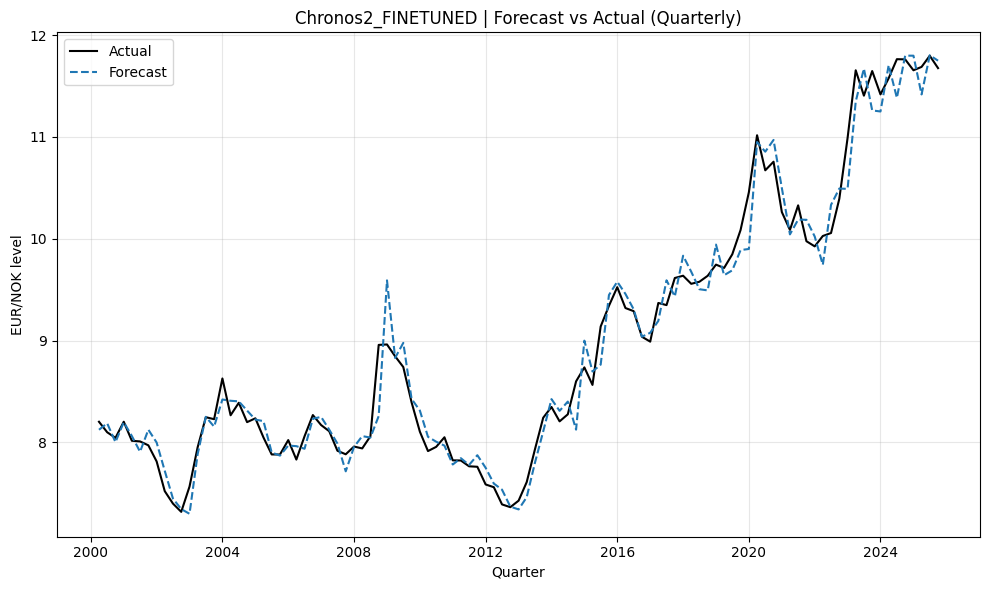

Saved: Chronos2_FINETUNED_Forecast_Q.png

=== Chronos2_FINETUNED | Hedging backtest (quarterly) ===
Exposure   : EUR_cost
Rule       : binary
Hedge cost : 0.00 bps/period
Mean r (unhedged): -0.00381 | Vol: 0.02649 | Sharpe~: -0.287
Mean r (hedged)  : 0.00532 | Vol: 0.01463 | Sharpe~: 0.728

=== Chronos2_FINETUNED | Øre-/NOK-forbedring (quarterly) ===
EUR notional: 1,000,000
Mean improvement: 8.023 øre/EUR per period | 91.29 bps/period
Median: 0.000 øre/EUR | P10/P90: -1.708/31.019
Share positive: 37.3%
Total improvement: 8,183,123 NOK over sample


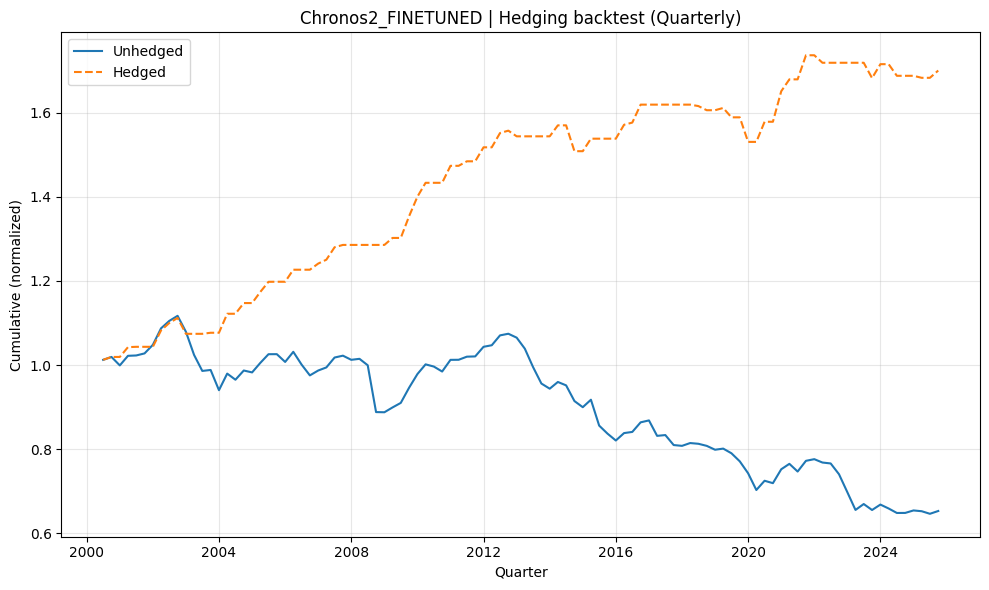

Saved: Chronos2_FINETUNED_Hedge_Q.png


In [6]:
!pip -q install pandas numpy scikit-learn matplotlib requests certifi torch chronos-forecasting

from __future__ import annotations
import io, time, math, inspect, warnings
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Callable, List

import numpy as np
import pandas as pd
import requests, certifi
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

import torch
from chronos import BaseChronosPipeline  # chronos-forecasting>=2.0


# =========================================================
# CONFIG
# =========================================================
@dataclass
class Config:
    # Main dataset (EUR/NOK + covariates)
    url_main: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )

    # Fine-tuning panel (NB FX 1980–1999)
    url_finetune: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/FineTuneData/NB1980-1999.csv"
    )

    # Walk-forward
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon_month: int = 64
    max_horizon_quarter: int = 128
    q_freq: str = "Q-DEC"

    # Hedging
    exposure: str = "EUR_cost"       # "EUR_asset" or "EUR_cost"
    hedge_rule: str = "binary"       # "binary" or "sigmoid"
    sigmoid_k: float = 8.0
    vol_lookback: int = 12
    hedge_cost_bps: float = 0.0      # per period (M/Q)

    # Øre/NOK quantification
    eur_notional: float = 1_000_000.0

    # Runtime
    retries: int = 3
    timeout: int = 60
    verbose: bool = True

CFG = Config()
TARGET = "EUR_NOK"


# =========================================================
# LOFO COVARIATE SETS (Chronos-2)
# =========================================================
# Monthly (from your LaTeX): {VIX, SP500, StoxEurope, OSEBX, OBX_EN, dI_t}
CHRONOS_COV_MONTHLY = ["VIX", "SP500", "StoxEurope", "OSEBX", "OBX_EN", "dI_t"]

# Quarterly (from your LaTeX): {VIX, SP500, q_t}
CHRONOS_COV_QUARTERLY = ["VIX", "SP500", "q_t"]


# =========================================================
# FINETUNE SETUP
# =========================================================
FINETUNE_FX_COLS = [
    "AUD", "CAD", "CHF", "DKK", "GBP",
    "ISK", "JPY", "NZD", "SEK", "USD", "XDR",
]

@dataclass
class FTConfig:
    prediction_length: int = 32
    num_steps: int = 20
    learning_rate: float = 5e-06
    batch_size: int = 4
    logging_steps: int = 10

BEST_FT_PARAMS = FTConfig()


# =========================================================
# HELPERS
# =========================================================
ALIASES = {
    "OBX_EN": ["OBX_Energy", "OBX_EN", "OBX_ENERGY", "OBX_EN_"],
    "q_t": ["Q", "q_t", "q"],
    "Q": ["Q", "q_t", "q"],
}

def resolve_columns(df_cols: List[str], wanted: List[str]) -> List[str]:
    cols = set(df_cols)
    out = []
    for w in wanted:
        if w in cols:
            out.append(w)
            continue
        if w in ALIASES:
            found = next((a for a in ALIASES[w] if a in cols), None)
            if found:
                out.append(found)
                continue
        raise ValueError(f"Missing column: {w}. Available sample: {sorted(cols)[:35]}")
    return out

def download_csv_text(url: str, retries: int, timeout: int) -> str:
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                time.sleep(1.5 * k)
    raise RuntimeError(f"Download failed: {last_err}")

def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


# =========================================================
# LOAD MAIN DATA (target + covs) -> business-day truth + daily panel
# =========================================================
def load_main(url: str, cov_cols: List[str]) -> Tuple[pd.Series, pd.DataFrame, List[str]]:
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    if "Date" not in raw.columns:
        raise ValueError("CSV must contain column 'Date'.")

    cov_resolved = resolve_columns(list(raw.columns), cov_cols)

    required = ["Date", TARGET] + cov_resolved
    df = (
        raw[required]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET])
        .sort_values("DATE")
        .set_index("DATE")
    )

    for c in [TARGET] + cov_resolved:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=[TARGET])

    if df.empty:
        raise ValueError("Main dataset empty after cleaning.")

    # Truth series on business days
    S_b = df[TARGET].asfreq("B").ffill().astype(float)
    S_b.name = TARGET

    # Daily panel (calendar days) for context
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d, cov_resolved

def make_pastcov_context(hist_wide: pd.DataFrame, cov_cols: List[str]) -> pd.DataFrame:
    ctx = pd.DataFrame({
        "timestamp": hist_wide.index,
        "item_id": TARGET,
        "target": hist_wide[TARGET].astype(float).values,
    })
    for c in cov_cols:
        ctx[c] = hist_wide[c].astype(float).values
    return ctx.sort_values("timestamp")


# =========================================================
# LOAD FINETUNE PANEL
# =========================================================
def load_finetune_fx_panel(url: str) -> pd.DataFrame:
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text), sep=";", decimal=".", encoding="utf-8-sig")

    required = ["ds"] + FINETUNE_FX_COLS
    missing = set(required) - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in fine-tune CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[required]
        .rename(columns={"ds": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], dayfirst=True, errors="coerce"))
        .dropna(subset=["DATE"])
        .sort_values("DATE")
        .set_index("DATE")
    )
    for c in FINETUNE_FX_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(how="all", subset=FINETUNE_FX_COLS)

    if df.empty:
        raise ValueError("Fine-tune panel empty after cleaning.")

    return df


# =========================================================
# CHRONOS PIPELINES
# =========================================================
def build_chronos_pipeline(pretrained: str = "amazon/chronos-2"):
    # Baseline forecasting can run on CPU; fine-tuning effectively requires CUDA.
    if torch.cuda.is_available():
        return BaseChronosPipeline.from_pretrained(
            pretrained,
            device_map="cuda",
            torch_dtype=torch.float16,
        )
    return BaseChronosPipeline.from_pretrained(
        pretrained,
        device_map="cpu",
        torch_dtype=torch.float32,
    )

def finetune_chronos_on_nb_panel(
    pipeline: BaseChronosPipeline,
    fx_panel: pd.DataFrame,
    ft_params: FTConfig,
) -> BaseChronosPipeline:
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Fine-tuning requires GPU.")

    train_inputs: List[Dict] = []
    for col in FINETUNE_FX_COLS:
        series = fx_panel[col].dropna().astype(np.float32).values
        if series.size < ft_params.prediction_length * 2:
            continue
        train_inputs.append({"target": series, "past_covariates": {}, "future_covariates": {}})

    if not train_inputs:
        raise RuntimeError("No valid series for fine-tuning (all too short / empty).")

    if CFG.verbose:
        print("\n[Fine-tuning Chronos-2 on NB FX panel]")
        print(f"  series_used={len(train_inputs)}")
        print(f"  pred_len={ft_params.prediction_length}, steps={ft_params.num_steps}, "
              f"lr={ft_params.learning_rate}, bs={ft_params.batch_size}")

    return pipeline.fit(
        inputs=train_inputs,
        prediction_length=ft_params.prediction_length,
        num_steps=ft_params.num_steps,
        learning_rate=ft_params.learning_rate,
        batch_size=ft_params.batch_size,
        logging_steps=ft_params.logging_steps,
    )


# =========================================================
# FORECASTER (past covariates, NO cross-learning; no warning spam)
# =========================================================
def build_chronos2_pastcov_forecaster(
    pipeline: BaseChronosPipeline,
    max_context: int
) -> Callable[[pd.DataFrame, int], pd.DataFrame]:

    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")

        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Unsupported Chronos schema: {list(df.columns)}")

        return df[["item_id", "timestamp", "y_pred"]].copy()

    sig = inspect.signature(pipeline.predict_df)
    has_cross_learning = "cross_learning" in sig.parameters
    has_predict_batches_jointly = "predict_batches_jointly" in sig.parameters

    def _forecast(context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        if len(context_df) > max_context:
            context_df = context_df.iloc[-max_context:].copy()

        kwargs = dict(
            prediction_length=H,
            quantile_levels=[0.5],
            id_column="item_id",
            timestamp_column="timestamp",
            target="target",
        )

        # New API: explicitly disable cross-learning
        if has_cross_learning:
            kwargs["cross_learning"] = False
        # Old API fallback (and suppress its deprecation warning)
        elif has_predict_batches_jointly:
            kwargs["predict_batches_jointly"] = False

        with torch.inference_mode():
            if (not has_cross_learning) and has_predict_batches_jointly:
                with warnings.catch_warnings():
                    warnings.filterwarnings(
                        "ignore",
                        category=FutureWarning,
                        message=r".*predict_batches_jointly.*deprecated.*",
                    )
                    pred = pipeline.predict_df(context_df, **kwargs)
            else:
                pred = pipeline.predict_df(context_df, **kwargs)

        return _extract_median(pred)

    return _forecast


# =========================================================
# WALK-FORWARD (monthly + quarterly)
# =========================================================
def walk_forward_monthly(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    cov_cols: List[str],
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
) -> pd.DataFrame:

    first_m = pd.Period(S_b.index.min(), freq="M")
    last_m  = pd.Period(S_b.index.max(), freq="M")
    months = pd.period_range(first_m, last_m, freq="M")

    rows: Dict[str, dict] = {}
    dropped: Dict[str, str] = {}

    for m in months:
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(m)] = "no_cut"; continue

        hist_wide = DF_d.loc[:cut]
        if hist_wide.shape[0] < CFG.min_hist_days:
            dropped[str(m)] = f"hist<{CFG.min_hist_days}"; continue

        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            dropped[str(m)] = "no_bdays"; continue
        y_true = float(S_b.loc[idx_m_b].mean())

        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon_month:
            dropped[str(m)] = f"bad_H(H={H})"; continue

        context_df = make_pastcov_context(hist_wide, cov_cols)
        df_pred = forecast_fn(context_df, H)
        if df_pred.empty:
            dropped[str(m)] = "no_pred"; continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        fx = df_pred[df_pred["item_id"] == TARGET].copy().sort_values("timestamp")

        pred_daily = pd.Series(index=f_idx, dtype=float)
        tmp = fx.set_index("timestamp")["y_pred"]
        common = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common] = tmp.loc[common]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_m_b, method=None)
        if pred_b.isna().all():
            dropped[str(m)] = "no_overlap_B"; continue
        y_pred = float(pred_b.dropna().mean())

        rows[str(m)] = {"month": m, "cut": cut, "y_true": y_true, "y_pred": y_pred}

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("month").sort_index()

    if CFG.verbose and dropped:
        print("\nDropped months and reasons:")
        for k, v in dropped.items():
            print(f"  {k}: {v}")

    return df

def walk_forward_quarterly(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    cov_cols: List[str],
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
) -> pd.DataFrame:

    first_q = pd.Period(S_b.index.min(), freq=CFG.q_freq)
    last_q  = pd.Period(S_b.index.max(), freq=CFG.q_freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.q_freq)

    rows: Dict[str, dict] = {}
    dropped: Dict[str, str] = {}

    for q in quarters:
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(q)] = "no_cut"; continue

        hist_wide = DF_d.loc[:cut]
        if hist_wide.shape[0] < CFG.min_hist_days:
            dropped[str(q)] = f"hist<{CFG.min_hist_days}"; continue

        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            dropped[str(q)] = "no_bdays"; continue
        y_true = float(S_b.loc[idx_q_b].mean())

        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon_quarter:
            dropped[str(q)] = f"bad_H(H={H})"; continue

        context_df = make_pastcov_context(hist_wide, cov_cols)
        df_pred = forecast_fn(context_df, H)
        if df_pred.empty:
            dropped[str(q)] = "no_pred"; continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        fx = df_pred[df_pred["item_id"] == TARGET].copy().sort_values("timestamp")

        pred_daily = pd.Series(index=f_idx, dtype=float)
        tmp = fx.set_index("timestamp")["y_pred"]
        common = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common] = tmp.loc[common]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            dropped[str(q)] = "no_overlap_B"; continue
        y_pred = float(pred_b.dropna().mean())

        rows[str(q)] = {"quarter": q, "cut": cut, "y_true": y_true, "y_pred": y_pred}

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("quarter").sort_index()

    if CFG.verbose and dropped:
        print("\nDropped quarters and reasons:")
        for k, v in dropped.items():
            print(f"  {k}: {v}")

    return df


# =========================================================
# EVAL + HEDGING + ØRE/NOK
# =========================================================
def evaluate_forecast(eval_df: pd.DataFrame, label: str, horizon: str) -> pd.DataFrame:
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true","y_pred"]).copy()

    rmse = float(np.sqrt(np.mean(core["err"]**2))) if len(core) else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if len(core) else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = hits/total if total else np.nan

    print(f"\n=== {label} | Forecast performance ({horizon}) ===")
    print(f"Obs: {len(core)}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE : {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core

def _sigmoid(x: float) -> float:
    return 1.0/(1.0+math.exp(-x))

def hedge_backtest(core: pd.DataFrame, label: str, horizon: str) -> pd.DataFrame:
    df = core.copy()
    df["y_prev"] = df["y_true"].shift(1)
    df = df.dropna(subset=["y_prev"]).copy()

    df["r_fx"]  = df["y_true"]/df["y_prev"] - 1.0
    df["r_hat"] = df["y_pred"]/df["y_prev"] - 1.0

    if CFG.exposure not in ("EUR_asset","EUR_cost"):
        raise ValueError("CFG.exposure must be 'EUR_asset' or 'EUR_cost'.")

    sign = -1.0 if CFG.exposure == "EUR_asset" else +1.0

    if CFG.hedge_rule == "binary":
        df["hedge_ratio"] = (sign * df["r_hat"] > 0).astype(float)
    elif CFG.hedge_rule == "sigmoid":
        vol = df["r_fx"].rolling(CFG.vol_lookback, min_periods=3).std().replace(0, np.nan)
        scale = vol.fillna(vol.median() if np.isfinite(vol.median()) else 1e-6)
        z = (sign * df["r_hat"]) / (scale + 1e-12)
        df["hedge_ratio"] = z.apply(lambda v: _sigmoid(CFG.sigmoid_k * float(v))).clip(0,1)
    else:
        raise ValueError("CFG.hedge_rule must be 'binary' or 'sigmoid'.")

    df["r_unhedged"] = df["r_fx"] if CFG.exposure == "EUR_asset" else -df["r_fx"]

    cost = (CFG.hedge_cost_bps/10000.0)
    df["r_hedged"] = (1.0 - df["hedge_ratio"]) * df["r_unhedged"] - cost

    df["cum_unhedged"] = (1.0 + df["r_unhedged"]).cumprod()
    df["cum_hedged"]   = (1.0 + df["r_hedged"]).cumprod()

    ann = math.sqrt(12) if horizon == "monthly" else math.sqrt(4)
    mu_u, sd_u = df["r_unhedged"].mean(), df["r_unhedged"].std(ddof=1)
    mu_h, sd_h = df["r_hedged"].mean(),   df["r_hedged"].std(ddof=1)
    sharpe_u = (mu_u/(sd_u+1e-12))*ann
    sharpe_h = (mu_h/(sd_h+1e-12))*ann

    print(f"\n=== {label} | Hedging backtest ({horizon}) ===")
    print(f"Exposure   : {CFG.exposure}")
    print(f"Rule       : {CFG.hedge_rule}")
    print(f"Hedge cost : {CFG.hedge_cost_bps:.2f} bps/period")
    print(f"Mean r (unhedged): {mu_u:.5f} | Vol: {sd_u:.5f} | Sharpe~: {sharpe_u:.3f}")
    print(f"Mean r (hedged)  : {mu_h:.5f} | Vol: {sd_h:.5f} | Sharpe~: {sharpe_h:.3f}")

    return df

def quantify_ore_improvement(bt: pd.DataFrame, label: str, horizon: str) -> pd.DataFrame:
    df = bt.copy()
    EURN = float(CFG.eur_notional)

    df["S_prev"] = df["y_prev"].astype(float)
    df["base_nok"] = EURN * df["S_prev"]

    df["pnl_unhedged_nok"] = df["r_unhedged"] * df["base_nok"]
    df["pnl_hedged_nok"]   = df["r_hedged"]   * df["base_nok"]

    df["improvement_nok"] = df["pnl_hedged_nok"] - df["pnl_unhedged_nok"]
    df["improvement_ore_per_eur"] = 100.0 * (df["improvement_nok"] / EURN)
    df["improvement_bps"] = 10000.0 * (df["improvement_nok"] / (df["base_nok"] + 1e-12))

    ore = df["improvement_ore_per_eur"].dropna()
    bps = df["improvement_bps"].dropna()

    print(f"\n=== {label} | Øre-/NOK-forbedring ({horizon}) ===")
    print(f"EUR notional: {EURN:,.0f}")
    print(f"Mean improvement: {ore.mean():.3f} øre/EUR per period | {bps.mean():.2f} bps/period")
    print(f"Median: {ore.median():.3f} øre/EUR | P10/P90: {ore.quantile(0.10):.3f}/{ore.quantile(0.90):.3f}")
    print(f"Share positive: {(ore.gt(0).mean()*100):.1f}%")
    print(f"Total improvement: {(df['improvement_nok'].sum()):,.0f} NOK over sample")

    return df


# =========================================================
# PLOTS
# =========================================================
def plot_forecast(core: pd.DataFrame, path: str, title: str, horizon: str):
    x = core.index.to_timestamp() if isinstance(core.index, pd.PeriodIndex) else core.index
    plt.figure(figsize=(10,6))
    plt.plot(x, core["y_true"], color="black", label="Actual")
    plt.plot(x, core["y_pred"], color="tab:blue", linestyle="--", label="Forecast")
    plt.title(title)
    plt.xlabel("Month" if horizon == "monthly" else "Quarter")
    plt.ylabel("EUR/NOK level")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved: {path}")

def plot_hedge(bt: pd.DataFrame, path: str, title: str, horizon: str):
    x = bt.index.to_timestamp() if isinstance(bt.index, pd.PeriodIndex) else bt.index
    plt.figure(figsize=(10,6))
    plt.plot(x, bt["cum_unhedged"], label="Unhedged")
    plt.plot(x, bt["cum_hedged"], linestyle="--", label="Hedged")
    plt.title(title)
    plt.xlabel("Month" if horizon == "monthly" else "Quarter")
    plt.ylabel("Cumulative (normalized)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved: {path}")


# =========================================================
# RUNNER
# =========================================================
def run_one_model(
    model_label: str,
    pipeline: BaseChronosPipeline,
    cov_monthly: List[str],
    cov_quarterly: List[str],
):
    # Monthly data
    S_b_m, DF_d_m, cov_m_res = load_main(CFG.url_main, cov_monthly)
    # Quarterly data
    S_b_q, DF_d_q, cov_q_res = load_main(CFG.url_main, cov_quarterly)

    if CFG.verbose:
        print("\n" + "="*90)
        print(f"MODEL: {model_label}")
        print("="*90)
        print(f"Monthly covariates (resolved):  {cov_m_res}")
        print(f"Quarterly covariates (resolved): {cov_q_res}")
        print(f"Data (B): {S_b_m.index.min().date()} → {S_b_m.index.max().date()} | n={len(S_b_m)}")
        print(f"Data (D): {DF_d_m.index.min().date()} → {DF_d_m.index.max().date()} | n={len(DF_d_m)}")

    forecast_fn = build_chronos2_pastcov_forecaster(pipeline, CFG.max_context)

    # ---------------- MONTHLY ----------------
    print("\n" + "="*90)
    print(f"RUN: {model_label} | HORIZON = MONTHLY")
    print("="*90)

    df_eval_m = walk_forward_monthly(S_b_m, DF_d_m, cov_m_res, forecast_fn)
    core_m = evaluate_forecast(df_eval_m, label=model_label, horizon="monthly")
    plot_forecast(core_m, f"{model_label}_Forecast_M.png",
                  f"{model_label} | Forecast vs Actual (Monthly)", "monthly")

    bt_m = hedge_backtest(core_m, label=model_label, horizon="monthly")
    bt_m = quantify_ore_improvement(bt_m, label=model_label, horizon="monthly")
    plot_hedge(bt_m, f"{model_label}_Hedge_M.png",
              f"{model_label} | Hedging backtest (Monthly)", "monthly")

    # ---------------- QUARTERLY ----------------
    print("\n" + "="*90)
    print(f"RUN: {model_label} | HORIZON = QUARTERLY")
    print("="*90)

    df_eval_q = walk_forward_quarterly(S_b_q, DF_d_q, cov_q_res, forecast_fn)
    core_q = evaluate_forecast(df_eval_q, label=model_label, horizon="quarterly")
    plot_forecast(core_q, f"{model_label}_Forecast_Q.png",
                  f"{model_label} | Forecast vs Actual (Quarterly)", "quarterly")

    bt_q = hedge_backtest(core_q, label=model_label, horizon="quarterly")
    bt_q = quantify_ore_improvement(bt_q, label=model_label, horizon="quarterly")
    plot_hedge(bt_q, f"{model_label}_Hedge_Q.png",
              f"{model_label} | Hedging backtest (Quarterly)", "quarterly")


def main():
    # ---------------- BASE ----------------
    base_pipe = build_chronos_pipeline("amazon/chronos-2")
    run_one_model(
        model_label="Chronos2_BASE",
        pipeline=base_pipe,
        cov_monthly=CHRONOS_COV_MONTHLY,
        cov_quarterly=CHRONOS_COV_QUARTERLY,
    )

    # ---------------- FINETUNED ----------------
    fx_panel = load_finetune_fx_panel(CFG.url_finetune)
    if CFG.verbose:
        print("\n" + "="*90)
        print("FINETUNE PANEL")
        print("="*90)
        print(f"Panel: {fx_panel.index.min().date()} → {fx_panel.index.max().date()} | n={len(fx_panel)}")
        print(f"Best params: {BEST_FT_PARAMS}")

    ft_base = build_chronos_pipeline("amazon/chronos-2")
    ft_pipe = finetune_chronos_on_nb_panel(ft_base, fx_panel, BEST_FT_PARAMS)

    run_one_model(
        model_label="Chronos2_FINETUNED",
        pipeline=ft_pipe,
        cov_monthly=CHRONOS_COV_MONTHLY,
        cov_quarterly=CHRONOS_COV_QUARTERLY,
    )

if __name__ == "__main__":
    main()
